# Data

## Imports and Definitions

In [1]:
from torch.utils.data import Dataset, DataLoader
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image

COCO2014_DATA_PATH = '../data/coco2014/'
WIKIART_DATA_PATH = '../data/wikiart/'
STYLE_PATH = '../data/style'

WIKIART_STYLE_MAP = {
    'Abstract_Expressionism': 1,
    'Action_painting': 2,
    'Analytical_Cubism': 3,
    'Art_Nouveau_Modern': 4,
    'Baroque': 5,
    'Color_Field_Painting': 6,
    'Contemporary_Realism': 7,
    'Cubism': 8,
    'Early_Renaissance': 9,
    'Expressionism': 10,
    'Fauvism': 11,
    'High_Renaissance': 12,
    'Impressionism': 13,
    'Mannerism_Late_Renaissance': 14,
    'Minimalism': 15,
    'Naive_Art_Primitivism': 16,
    'New_Realism': 17,
    'Northern_Renaissance': 18,
    'Pointillism': 19,
    'Pop_Art': 20,
    'Post_Impressionism': 21,
    'Realism': 22,
    'Rococo': 23,
    'Romanticism': 24,
    'Symbolism': 25,
    'Synthetic_Cubism': 26,
    'Ukiyo_e': 27,
}

## Data Pre-processing

In [ ]:
"""
Initial Data structure
/data
    /coco2014
        /annotations
        /images
            /test2014
            /train2014
            /val2014
        /labels
    /wikiart
        /Abstract_Expressionism
            /aaron-siskind_acolman-1-1955.jpg
            ...
        /Action_painting
        ...
        /Ukiyo_e
        /classes.csv
        /wclasses.csv
        
Target Data structure
/data
    /coco2014
        /annotations
        /images
            /test2014
            /train2014
            /val2014
        /labels
    /style
        /test
        /train
        /val
"""

#### a) Flatten WikiArt Dataset

In [2]:
def flatten_data(ignore=[], src=WIKIART_DATA_PATH):
    """
    Given a directory src, unpack the contents of its sub-directories into the directory src. The names of the sub-directories in the 'ignore' list are not unpacked
    """
    subdirs = [dir for dir in os.listdir(src) if os.path.isdir(os.path.join(src, dir)) and dir not in ignore]

    for dir in subdirs:
        subdir_path = os.path.join(src, dir)
        files = os.listdir(subdir_path)
        loop = tqdm(files)
        loop.set_description(f'Unpacking sub-directory {dir}')
        for file in loop:
            # Prepend the style class the file is from
            os.rename(os.path.join(subdir_path, file), os.path.join(src, dir + '_' + file))
            
        os.rmdir(subdir_path)

In [3]:
flatten_data()

Unpacking sub-directory Analytical_Cubism: 100%|██████████| 110/110 [00:00<00:00, 50789.68it/s]
Unpacking sub-directory Mannerism_Late_Renaissance: 100%|██████████| 1279/1279 [00:00<00:00, 77153.96it/s]
Unpacking sub-directory Fauvism: 100%|██████████| 934/934 [00:00<00:00, 71220.43it/s]


#### b) Create WikiArt data splits

In [4]:
def make_split(src, dest, files, ttv):
    """
    Write files from src to dest
    """
    loop = tqdm(files, total=len(files))
    loop.set_description(f"Writing {ttv} split")
    for file in loop:
        src_path = os.path.join(src, file)
        dest_path = os.path.join(dest, file)
        shutil.copyfile(src_path, dest_path)

def split_data(src, dest, split_size=0.8, max_files=30000, random_seed=42):
    """
    Given a directory src, create train, val, and test split directories in directory dest
    """
    random.seed(random_seed)
    if not (0 < split_size < 1):
        raise ValueError(f"split_size must be between 0 and 1. Got: {split_size}")
    
    all_files = [file for file in os.listdir(src) if file.endswith('.jpg')]
    
    if not all_files:
        raise ValueError(f"src directory did not contain any files")
    
    
    if len(all_files) > max_files:
        all_files = all_files[:max_files]
        
    random.shuffle(all_files)
        
    train_files, remaining_files = train_test_split(all_files, train_size=split_size, random_state=random_seed)
    
    validation_files, test_files = train_test_split(remaining_files, test_size=0.5, random_state=random_seed)
    
    # Make destination directories
    split = ['train', 'val', 'test']
    
    for ttv in split:
        split_path = os.path.join(dest, ttv)
        if os.path.exists(split_path):
            shutil.rmtree(split_path)
        
        os.makedirs(split_path, exist_ok=True)
        
    make_split(src, os.path.join(dest, 'train'), train_files, 'train')
    make_split(src, os.path.join(dest, 'val'), validation_files, 'val')
    make_split(src, os.path.join(dest, 'test'), test_files, 'test')
    

In [5]:
split_data(WIKIART_DATA_PATH, STYLE_PATH, 0.8)

Writing test split: 100%|██████████| 2644/2644 [00:13<00:00, 194.81it/s]


## Dataset and DataLoaders

In [23]:
class COCO2014(Dataset):
    def __init__(self, split, max_files, transform=None):
        if split not in ['train', 'val', 'test']:
            raise ValueError(f"split must be 'train', 'val', or 'test'. Got: {split}")
        
        split = split + '2014'
        self.image_path = os.path.join(COCO2014_DATA_PATH, 'images', split)
        images = os.listdir(self.image_path)
        
        if len(images) > max_files:
            images = images[:max_files]
        
        self.images = images
        self.length = len(images)
        self.transform = transform
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img = Image.open(os.path.join(self.image_path, img_name)).convert('RGB')
        
        if self.transform:
            img = self.transform(img)

        return img

class StyleDataset(Dataset):
    def __init__(self, ttv, transform=None):
        self.image_path = os.path.join(STYLE_PATH, ttv)
        self.images = os.listdir(self.image_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img = Image.open(os.path.join(self.image_path, img_name)).convert('RGB')

        img_style = [s for s in img_name.split('_') if s[0].isupper() or (s[0] == 'e' and len(s) == 1)]
        label = WIKIART_STYLE_MAP["_".join(img_style)]

        if self.transform:
            img = self.transform(img)
            
        return img, label

In [20]:
import torchvision.transforms as transforms

train_tf = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

In [24]:
content_trainset = COCO2014('train', 24000, train_tf)
content_validset = COCO2014('val', 3000, val_tf)
style_trainset = StyleDataset('train', transform=train_tf)
style_validset = StyleDataset('val', transform=val_tf)

content_trainloader = DataLoader(content_trainset, 64, shuffle=True)
content_validloader = DataLoader(content_validset, 64, shuffle=False)
style_trainloader = DataLoader(style_trainset, 64, shuffle=True)
style_validloader = DataLoader(style_validset, 64, shuffle=False)

## Data Sources and Exploratory Analysis of Data

### Data Sources

The COCO 2014 Dataset on [Kaggle](https://www.kaggle.com/datasets/jeffaudi/coco-2014-dataset-for-yolov3/) is a popular dataset developed by [Lin et al.](https://arxiv.org/pdf/1405.0312) with 80 classes, 82,783 training and 40,504 validation images in RGB format. During image collection, the authors filtered out iconic images in favour of non-iconic images. Iconic images are characterised by single large objects in a canonical perspective centered in the image. Evidently, research from [Torralba and Efros](https://ieeexplore-ieee-org.wwwproxy1.library.unsw.edu.au/document/5995347) indicates that a lack of contextual information and non-canonical viewpoints in iconic images may lead to decreased generalization of datasets from capture bias and negative set bias. Therefore, by removing iconic images, the COCO dataset is well-generalised and provides rich contextual relationships between objects in their natural environments. For the task of image style transfer, the COCO 2014 dataset is an exceptional source for 'content' images. Chiefly, the prevalance of non-iconic images provide diverse structural features which challenge the robustness and efficacy of style transfer model performance. For example, models like AdaAttn and MAST hyper-fixate on local structure leading to style leakage [(Xu et al.)](https://arxiv.org/abs/2304.00414). Contributing to the diverse structural features is the breadth of object classes collected for this dataset which will challenge a model's ability to generalize.

The WikiArt Dataset accessed from [Kaggle](https://www.kaggle.com/datasets/steubk/wikiart) is dataset of 80,020 images from 1119 different artists with 27 distinct styles classes. The images are sourced from WikiArt.org, an encylopedia of art. Combined, the 27 styles classes offer a wide range of unique salient features ranging from the small visible brushstrokes of 'Impressionism', the vibrant and bold colouring of 'Fauvism' to visually blending of small dots of colour which define 'Pointillism'. For the task of image style transfer, the WikiArt dataset is a standard benchmark for 'style' images used across research. The large number of classes alongside the depth of salient features makes WikiArt useful in evaluating the robustness and reliability of transferring artistic styles while preserving style patterns.

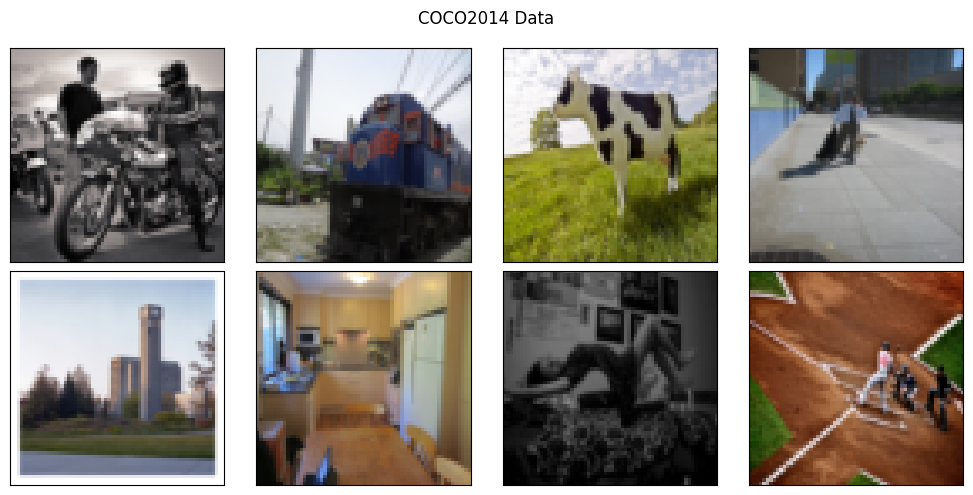

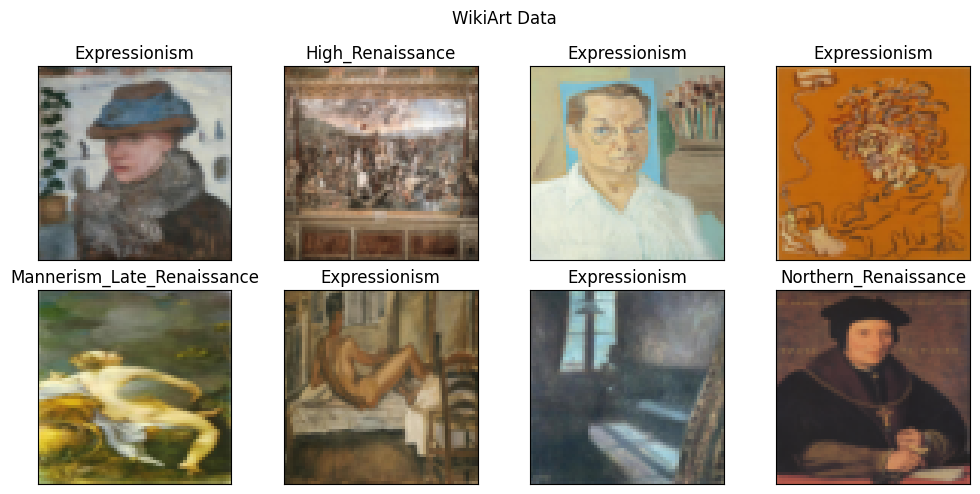

In [25]:
import matplotlib.pyplot as plt

def plot_dataset(loader, title, styleset=False):
    """
    Plot images from a batch of a DataLoader
    Args:
        loader (iterable) - a Pytorch DataLoader class
    """
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
    for batch in loader:
        for i, ax in enumerate(axes.flat):
            if styleset:
                images, labels = batch
                label = list(WIKIART_STYLE_MAP.keys())[list(WIKIART_STYLE_MAP.values()).index(labels[i])]
                ax.set_title(label)
            else:
                images = batch
            image = images[i].permute(1, 2, 0)
            ax.imshow(image)
        break

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
plot_dataset(content_trainloader, 'COCO2014 Data')
plot_dataset(style_trainloader, 'WikiArt Data', styleset=True)